In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
import glob
import cv2
from keras.utils import to_categorical
import keras
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
train = pd.read_csv('../input/train-data/traina_3.csv')

In [3]:
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
len(train)

3346

In [5]:
x_train = [cv2.resize(np.asarray(Image.open('../input/aptos2019-blindness-detection/train_images/'+i+'.png')),(256,256)) for i in train.id_code]

In [6]:
x_train = np.array(x_train)

In [7]:
x_train = np.array(x_train)

In [8]:
y_train = train.diagnosis

In [9]:
y_train = to_categorical(y_train)
y_train

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [10]:
s = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=7)
s.get_n_splits(x_train, y_train)
for train_index, test_index in s.split(x_train, y_train):
    x_traino, x_testo = x_train[train_index], x_train[test_index]
    y_traino, y_testo = y_train[train_index], y_train[test_index]

In [11]:
m1 = keras.applications.densenet.DenseNet121(input_shape=(256,256,3),include_top=True,weights=None)

In [12]:
m1.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [13]:
m1.load_weights('../input/densenet-keras/DenseNet-BC-121-32.h5')

In [14]:
x = m1.layers[-2].output
d = keras.layers.Dense(512,activation='relu')(x)
e = keras.layers.Dense(5,activation='softmax')(d)

In [15]:
m2 = keras.models.Model(m1.input,e)

In [16]:
m2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [45]:
m2.fit(x_traino,y_traino,validation_data=(x_testo,y_testo),epochs=20)

Epoch 1/20
84/84 [==============================] - 20s 241ms/step - loss: 0.0575 - accuracy: 0.9794 - val_loss: 1.1683 - val_accuracy: 0.7731
Epoch 2/20
84/84 [==============================] - 20s 239ms/step - loss: 0.0579 - accuracy: 0.9780 - val_loss: 1.2271 - val_accuracy: 0.8000
Epoch 3/20
84/84 [==============================] - 20s 239ms/step - loss: 0.0861 - accuracy: 0.9690 - val_loss: 1.1214 - val_accuracy: 0.7955
Epoch 4/20
84/84 [==============================] - 20s 240ms/step - loss: 0.0647 - accuracy: 0.9798 - val_loss: 1.0510 - val_accuracy: 0.8015
Epoch 5/20
84/84 [==============================] - 20s 239ms/step - loss: 0.0673 - accuracy: 0.9753 - val_loss: 1.3983 - val_accuracy: 0.7761
Epoch 6/20
84/84 [==============================] - 20s 239ms/step - loss: 0.0408 - accuracy: 0.9821 - val_loss: 1.1229 - val_accuracy: 0.8104
Epoch 7/20
84/84 [==============================] - 20s 239ms/step - loss: 0.0649 - accuracy: 0.9787 - val_loss: 1.3767 - val_accuracy: 0.7821

In [46]:
test1 = []
test_rd = pd.read_csv('../input/test-data/testa_3.csv')

In [47]:
for i in test_rd.id_code:
    tp = np.array(cv2.resize(np.array(Image.open('../input/aptos2019-blindness-detection/train_images/'+i+'.png')),(256,256)))
    test1.append(tp)

In [48]:
test1 = np.array(test1)

In [49]:
np.random.seed(42)
res_1 = m2.predict(test1)

In [50]:
res_2 = []
for i in res_1:
    res_2.append(np.argmax(i))

In [51]:
test2 = pd.DataFrame({"id_code": test_rd["id_code"].values, "diagnosis": res_2})
test2.head(20)

,id_code,diagnosis
0,e96099b961b4,2
1,e966850247f4,0
2,e9678824215d,0
3,e96bd80a8a53,1
4,e97ecf4355cb,0
5,e9ab8413e771,2
6,e9ce5bf645ab,0
7,e9f3c85a2a02,0
8,e9f82b5bbaf4,2
9,e9faf0296643,0


In [52]:
test2.to_csv('submission.csv',index=False)

In [53]:
dtest = pd.read_csv('../input/test-cmp/traina_testa_compare_3.csv')

In [54]:
A = test2["diagnosis"]

In [55]:
B = dtest["diagnosis"]

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


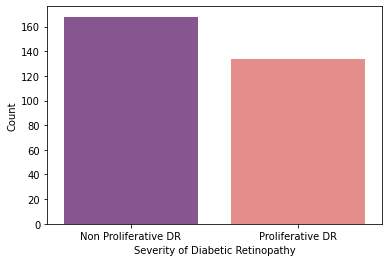

In [56]:
import seaborn as sns
clu = ["Non Proliferative DR","Proliferative DR"]
v=0
v1=0
for i in A:
    if (i==0):
        v=v+1
    else:
        v1=v1+1
uo=[v,v1]
V = True
if V:
    sns.barplot(clu, uo, alpha=0.8, palette='magma')
    plt.xlabel("Severity of Diabetic Retinopathy")
    plt.ylabel("Count")
    plt.show()

In [57]:
C = []
for i in A:
    if(i==0):
        lu=0
        C.append(lu)
    else:
        lus=1
        C.append(lus)

In [58]:
D = []
for i in B:
    if(i==0):
        lu=0
        D.append(lu)
    else:
        lus=1
        D.append(lus)

In [59]:
from sklearn.metrics import accuracy_score

In [60]:
accuracy_score(C,D)

0.9735099337748344

In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
C_M = confusion_matrix(C,D)

In [63]:
import seaborn as sns

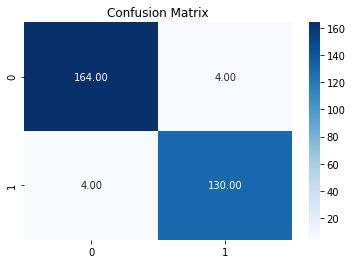

In [64]:
sns.heatmap(C_M, annot=True, fmt='.2f', cmap="Blues").set_title('Confusion Matrix')
plt.show()

In [65]:
from sklearn.metrics import classification_report

In [66]:
print (classification_report(C,D))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       168
           1       0.97      0.97      0.97       134

    accuracy                           0.97       302
   macro avg       0.97      0.97      0.97       302
weighted avg       0.97      0.97      0.97       302



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


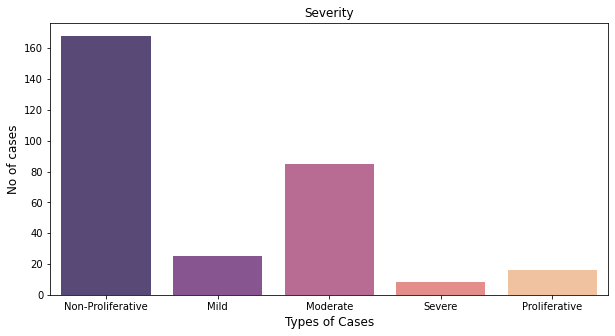

In [67]:
clu = ["Non-Proliferative","Mild", "Moderate", "Severe", "Proliferative" ]
ddr=0
ddr1=0
ddr2=0
ddr3=0
ddr4=0
for i in A:
    if (i==0):
        ddr=ddr+1
    elif(i==1):
        ddr1=ddr1+1
    elif(i==2):
        ddr2=ddr2+1
    elif(i==3):
        ddr3=ddr3+1
    elif(i==4):
        ddr4=ddr4+1    
uo=[ddr,ddr1,ddr2,ddr3,ddr4]
V = True
if V:
    
    plt.figure(figsize=(10,5))
    sns.barplot(clu, uo, alpha=0.8, palette='magma')
    plt.title('Severity')
    plt.ylabel('No of cases', fontsize=12)
    plt.xlabel('Types of Cases', fontsize=12)
    plt.show()

In [68]:
cf_matrix = confusion_matrix(A,B)

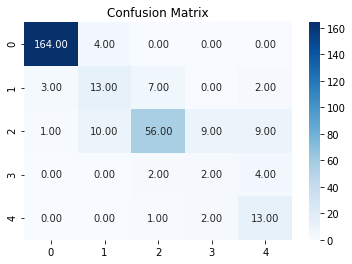

In [69]:
sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap="Blues").set_title('Confusion Matrix')
plt.show()

In [70]:
accuracy_score(A,B)

0.8211920529801324

In [71]:
print (classification_report(A,B))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       168
           1       0.48      0.52      0.50        25
           2       0.85      0.66      0.74        85
           3       0.15      0.25      0.19         8
           4       0.46      0.81      0.59        16

    accuracy                           0.82       302
   macro avg       0.58      0.64      0.60       302
weighted avg       0.85      0.82      0.83       302

